<img src="IMG/logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales - Segundo Cuatrimestre 2025

# TS9: Filtrado No Lineal
#### Matías Cassino 

# Consignas
En la TS7 se experimentaron técnicas de filtrado lineal para la mitigación de interferencias en la señal electrocardiográfica (ECG). Tal vez la interferencia que más exigió el diseño de los filtros digitales ha sido el movimiento de línea de base del ECG. La misma se trata de oscilaciones de muy baja frecuencia (< 0.5 Hz) y en ocaciones de alta energía. En esta tarea semanal se analizarán técnicas no lineales de estimación/substracción de la señal de movimiento de base $b(n)$.

$\hat{x} = s - \hat{b}$

Siendo $s$ la señal de ECG registrada con interferencias, y $\hat{x}$ la señal filtrada, una estimación del ECG sin interferencias. 

Se pide que implemente ambas estimaciones de $b$ detalladas a continuación:

1) Filtro de mediana
   
Se estima $\hat{b}$ a partir de la siguiente expresión:

$\hat{b}=med_{600}(med_{200}(s))$

siendo $med_{t}(s)$ el operador de mediana de $t$ milisegundos que se aplica sobre la señal $s$, es decir:

$\hat{b}=med(m[n],m[n−1],...,m[n−600⋅fs])$

donde 

$m[n]=med(s[n],s[n−1],...,s[n−200⋅fs])$

Ayuda: Puede utilizar la implementación del filtro de mediana provista en scipy.signal

2) Interpolación mediante splines cúbicos

A partir de las detecciones provistas en ecg.mat (campo qrs_detections), puede estimar el nivel isoeléctrico, es decir el momento donde la actividad eléctrica cardíaca es aproximadamente nula. El intervalo entre la onda P y Q, es el momento más adecuado para estimar las características de la la interferencia que originan el movimiento de la línea de base. En ese momento el impulso cardíaco es demorado al atravesar el nódulo aurículo-ventricular.

Para la localización del segmento PQ puede valerse de la localización de cada latido (líneas rojas verticales $(n_{i})$ y a partir de la misma, anticipar un tiempo adecuado $(n_{0})$ de manera tal de no incluir la onda P ni Q. Esto resultará en un conjunto valores  

$S={(m-{i}, s(m_{i}))|i=1,2,…,Q}$

donde $m_{i}=n_{i}−n_{0}$ y $Q$ es la cantidad de latidos en el registro (1903).

Recuerde que la señal de línea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que debería remuestrear dicha señal (puede usar la función de interpolación spline para ello).

$\hat{b}(n)=spline_{3}(S,n)|n=1,2,…,N$

donde la función $spline_{3}$ será la responsable de realizar la interpolación para las $N$ muestras de la señal $s$.

3) Filtro adaptado (matched filter)
   
Aplique el concepto de filtro adaptado para diseñar un detector de latidos. Utilice el patrón provisto en el campo qrs_pattern1.

Ayuda: Revise el concepto de filtro adaptado en Wikipedia, o la bibliografía de la materia (Porat 14.4.9).

a) Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado. Discuta la utilidad y limitaciones de este método.

b) Realice la detección de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable qrs_detections. Proponga alguna métrica (sensibilidad, valor predictivo positivo) para cuantificar la performance del detector

Bonus: 

1. Proponga alguna mejora a los estimadores de la señal b, como por ejemplo usar las técnicas multirate.

2. ¿Podría funcionar el detector basado en el filtro adaptado con un latido perteneciente a otro registro o paciente?

# Introducción
En este trabajo se aborda la estimación y sustracción del ruido de baja frecuencia correspondiente a una señal de ECG por medio de técnica no lineales. Por un lado, el filtro de mediana, el cual es robusto ante valores atípico, y la interpolación con splines cúbicos, que modela señales suavemente a partir de nodos de interés, enfatizan la aproximación de la línea de base. Por otro lado, el filtro adaptado pretende detectar los complejos QRS maximizando la SNR a través de la correlación de la señal con un patrón, y se evalúa ponderando la métricas resultantes de implementar la matriz de confusión.
Por último, se emplean técnicas multirate sobre el filtro de mediana, y se analiza la viabilidad de la generalización del detector de latidos dado por el filtro adaptado.

# Desarrollo experimental

In [1]:
#%% Módulos
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy.io as sio
from matplotlib import patches
from pytc2.sistemas_lineales import plot_plantilla
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

plt.close('all')

#%% Funciones
def matriz_confusion_qrs(mis_qrs, qrs_det, tolerancia_ms=150, fs=1000):
    """
    Calcula matriz de confusión para detecciones QRS usando solo NumPy y SciPy
    
    Parámetros:
    - mis_qrs: array con tiempos de tus detecciones (muestras)
    - qrs_det: array con tiempos de referencia (muestras)  
    - tolerancia_ms: tolerancia en milisegundos (default 150ms)
    - fs: frecuencia de muestreo (default 360 Hz)
    """
    
    # Convertir a arrays numpy
    mis_qrs = np.array(mis_qrs)
    qrs_det = np.array(qrs_det)
    
    # Convertir tolerancia a muestras
    tolerancia_muestras = tolerancia_ms * fs / 1000
    
    # Inicializar contadores
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    
    # Arrays para marcar detecciones ya emparejadas
    mis_qrs_emparejados = np.zeros(len(mis_qrs), dtype=bool)
    qrs_det_emparejados = np.zeros(len(qrs_det), dtype=bool)
    
    # Encontrar True Positives (detecciones que coinciden dentro de la tolerancia)
    for i, det in enumerate(mis_qrs):
        diferencias = np.abs(qrs_det - det)
        min_diff_idx = np.argmin(diferencias)
        min_diff = diferencias[min_diff_idx]
        
        if min_diff <= tolerancia_muestras and not qrs_det_emparejados[min_diff_idx]:
            TP += 1
            mis_qrs_emparejados[i] = True
            qrs_det_emparejados[min_diff_idx] = True
    
    # False Positives (tus detecciones no emparejadas)
    tp_idx=np.where(mis_qrs_emparejados)[0]
    fp_idx=np.where(~mis_qrs_emparejados)[0] #índices de detecciones falsas
    FP = np.sum(~mis_qrs_emparejados)
    
    # False Negatives (detecciones de referencia no emparejadas)
    fn_idx=np.where(~qrs_det_emparejados)[0]
    FN = np.sum(~qrs_det_emparejados)
    
    # Construir matriz de confusión
    matriz = np.array([
        [TP, FP],
        [FN, 0]  # TN generalmente no aplica en detección de eventos
    ])
    
    print("Matriz de Confusión:")
    print(f"           Predicho")
    print(f"           Sí    No")
    print(f"Real Sí:  [{TP:2d}   {FN:2d}]")
    print(f"Real No:  [{FP:2d}    - ]")
    print(f"\nTP: {TP}, FP: {FP}, FN: {FN}")

    # Calcular métricas de performance
    if TP + FP > 0:
        precision = TP / (TP + FP) #valor predictivo positivo
    else:
        precision = 0

    if TP + FN > 0:
        recall = TP / (TP + FN)
    else:
        recall = 0

    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    print(f"\nMétricas:")
    print(f"Precisión: {precision:.3f}")
    print(f"Sensibilidad: {recall:.3f}")
    print(f"F1-score: {f1_score:.3f}")
    
    return matriz, TP, FP, FN, tp_idx, fp_idx, fn_idx

#%% Parámetros y funciones
sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
qrs_detections=mat_struct['qrs_detections'].flatten()
qrs_pattern1=mat_struct['qrs_pattern1'].flatten()
qrs_pattern1=qrs_pattern1.astype(float)
cant_muestras=N
fs=1000

# Análisis de resultados

1) Filtro de mediana

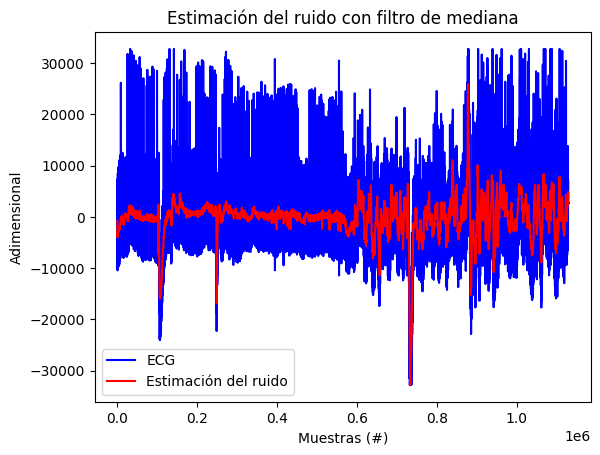

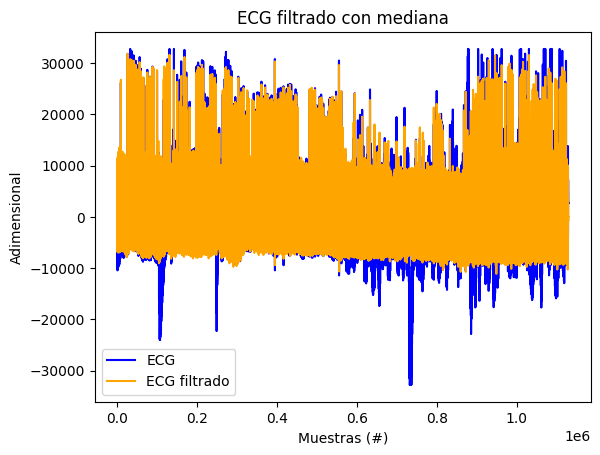

In [2]:
# Mediana
size=199 #muestras, y en mitad toma el valor enterno en lugar de una cant muestras par
filt_med_200=sig.medfilt(volume=ecg_one_lead,kernel_size=size)
bm=sig.medfilt(volume=filt_med_200,kernel_size=size*3) #ruido estimado
ecg_filt_med=ecg_one_lead-bm # sustracción

plt.figure()
plt.title('Estimación del ruido con filtro de mediana')
plt.plot(ecg_one_lead, color='blue', label='ECG')
plt.plot(bm, color='red', label='Estimación del ruido')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()

plt.figure()
plt.title('ECG filtrado con mediana')
plt.plot(ecg_one_lead, color='blue', label='ECG')
plt.plot(ecg_filt_med, color='orange', label='ECG filtrado')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()

- En las figuras, se expone el filtrado no lineal de mediana, el cual es más robusto que la media dado que suprime los valores de mayor magnitud (outliers) en las ventanas temporales consideras y permite mejores resultados ante señales rápidas. Concretamente, el soporte de 200 ms suprime las transiciones abruptas del complejo QRS (70 a 150 ms) mientras que el de 600 ms opera sobre las ondas T y P (100 a 300 ms), que poseen mayor desarrollo temporal. Sin embargo, la señal de ruido estimada posee valores constantes dado su carácter y, por ende, incide en la morfología de la señal resultante a baja frecuencia.

2) Interpolación mediante splines cúbicos 

C:\Users\Nancy\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Nancy\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


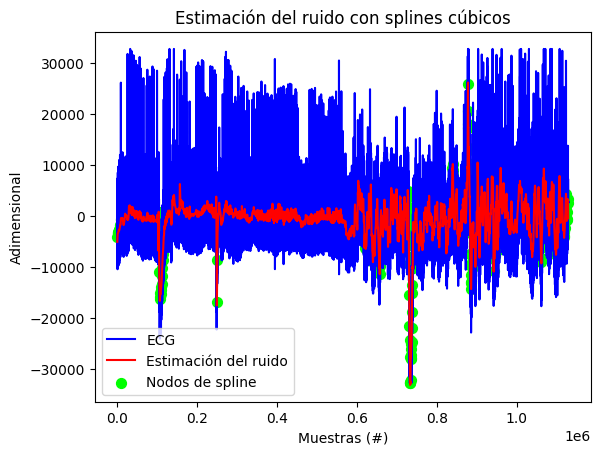

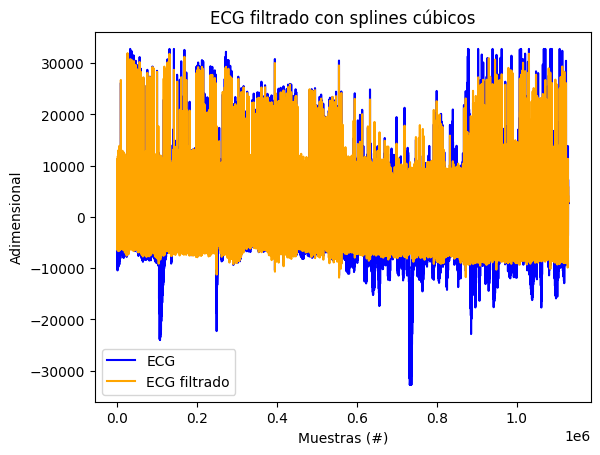

In [3]:
# Spline cúbico
n=80
m=qrs_detections-n
valor=ecg_one_lead[m]
cubico=CubicSpline(y=valor, x=m) #interpolante
N_vector=np.arange(N)
bs=cubico(N_vector) #ruido estimado y remuestreo
ecg_filt_bs=ecg_one_lead-bs # sustracción

plt.figure()
plt.title('Estimación del ruido con splines cúbicos')
plt.plot(ecg_one_lead, color='blue', label='ECG')
#plt.plot(ecg_filt_bs, color='green', label='ECG filtrado')
plt.plot(bs, color='red',  label='Estimación del ruido')
plt.scatter(m, valor, color='lime', s=50, label="Nodos de spline")
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
#plt.vlines(qrs_detections, ymin=min(ecg_one_lead), ymax=max(ecg_one_lead), colors='m', linestyles= 'dashed', linewidth=0.1)
plt.legend()

plt.figure()
plt.title('ECG filtrado con splines cúbicos')
plt.plot(ecg_one_lead, color='blue', label='ECG')
plt.plot(ecg_filt_bs, color='orange', label='ECG filtrado')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
#plt.vlines(qrs_detections, ymin=min(ecg_one_lead), ymax=max(ecg_one_lead), colors='m', linestyles= 'dashed', linewidth=0.1)
plt.legend()

- En el gráfico, se exhibe el filtrado a través de la interpolación con splines cúbicos, el cual es el más suave de los métodos no lineales debido a que soporta tres derivadas y, en consecuencia, posibilita una óptima estimación del movimiento de la línea de base para así suprimirlo. Pero, paralelamente, introduce no linealidades en secciones sin ruido, a pesar de los nodos de referencia, ya que es susceptible a señales con morfología heterogénea.

3)  Filtro adaptado (matched filter)

Matriz de Confusión:
           Predicho
           Sí    No
Real Sí:  [1902    1]
Real No:  [ 2    - ]

TP: 1902, FP: 2, FN: 1

Métricas:
Precisión: 0.999
Sensibilidad: 0.999
F1-score: 0.999


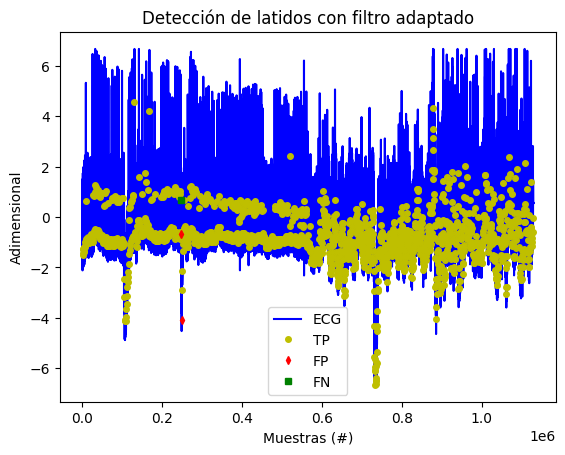

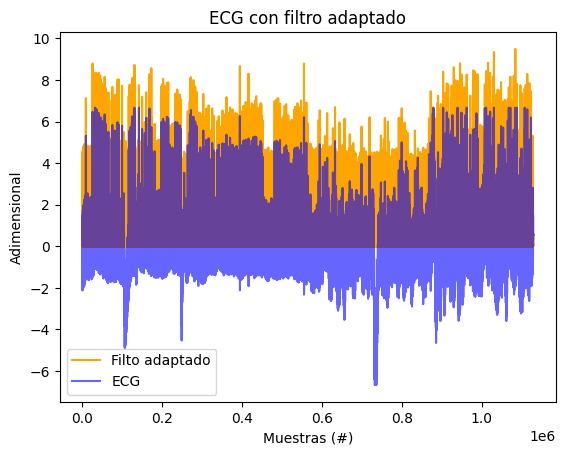

In [4]:
# Filtro adaptado
patron=(qrs_pattern1-np.mean(qrs_pattern1)).flatten()
ecg_filt_adp=sig.lfilter(b=patron,a=1,x=ecg_one_lead)
ecg_filt_adp_abs=np.abs(ecg_filt_adp)
#Normalización por desvio estándar para llevar a misma escala
ecg_filt_adp_abs_norm=ecg_filt_adp_abs/np.std(ecg_filt_adp_abs)
ecg_one_lead_norm=ecg_one_lead/np.std(ecg_one_lead)
#Retardo inherente de sist. lineal no simétrico, y lo compenso mediante las muestras ploteadas
ecg_filt_adp_abs_norm_demo=ecg_filt_adp_abs_norm[50:]
mis_qrs_detections,prominencias=sig.find_peaks(x=ecg_filt_adp_abs_norm_demo,height=1,distance=302)
#Establezco parámetros según el mínimo pico a detectar dado el SNR

matriz, tp, fp, fn, tp_idx, fp_idx, fn_idx = matriz_confusion_qrs(mis_qrs_detections, qrs_detections)

plt.figure()
plt.title('Detección de latidos con filtro adaptado')
plt.plot(ecg_one_lead_norm, color='blue', label='ECG')
# plt.plot(ecg_filt_adp_abs_norm_demo, label='filt_adp', color='orange')
plt.plot(mis_qrs_detections[tp_idx],ecg_one_lead_norm[mis_qrs_detections[tp_idx]],'oy',label='TP', markersize=4)
plt.plot(mis_qrs_detections[fp_idx],ecg_one_lead_norm[mis_qrs_detections[fp_idx]],'dr',label='FP',markersize=4)
plt.plot(qrs_detections[fn_idx],ecg_one_lead_norm[qrs_detections[fn_idx]],'sg',label='FN',markersize=4)
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()

plt.figure()
plt.title('ECG con filtro adaptado')
plt.plot(ecg_filt_adp_abs_norm_demo, label='Filto adaptado', color='orange')
plt.plot(ecg_one_lead_norm, color='blue', label='ECG', alpha=0.6)
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()

- A) En el gráfico, se presenta la aplicación del filtro adaptado que consiste en la correlación entre la señal y un patrón que maximiza el SNR en las secciónes correladas, es decir, potencia la energía cuando la morfología coincide con el patrón, posee valor medio nulo y suprime el ruido de baja frecuencia dado que este se considera como una constante en la correlación, por lo tanto, las áreas se compensan y se mitiga lo incorrelado.
Además, este debe normalizarse para escalarse ante la señal, y calibrarse a través de la demora para así sincronizarse dado su carácter no lineal.
En adición, el mismo puede complementarse con un filtro pasa bajos que detecte con mayor suavidad la envolvente del complejo QRS pero, en efecto, se limita el rango dinámico.
También, las detecciones de los valores máximos absolutos no coinciden precisamente con el extremo de la onda R sino que se sitúan en la pendiente de estas, y debe ponderarse la distancia temporal entre picos así como también un umbral de altura a fin de soslayar detecciones erróneas derivadas de las ondas T prominentes y el ruido.

- B) Tal como se establece en la matriz de confusión generada en función de las detecciones de la variable "qrs_detections" y las obtenidas por medio del filtro adaptado, ambas fuentes coinciden en 1902 puntos, por ende, los verdaderos positivos (TP). Sin embargo, los 2 falsos positivos (FP) son detecciones efectivas introducidas por el filtro, las cuales no se encuentran en el vector original proporcionado para la contraposición, y el único falso negativo (FN) deriva de un valor incorrectamente ubicado en la onda T por parte del vector de datos, pero detectado apropiadamente por el filtro sobre el complejo QRS más cercano ante el ajuste del espaciado temporal.
Simultáneamente, las métricas de sensibilidad y precisión, con valores del 99,9%, definen la fidelidad y reproducibilidad del detector desarrollado en función del ratio de latidos verdaderos y encontrados.

Bonus 1)

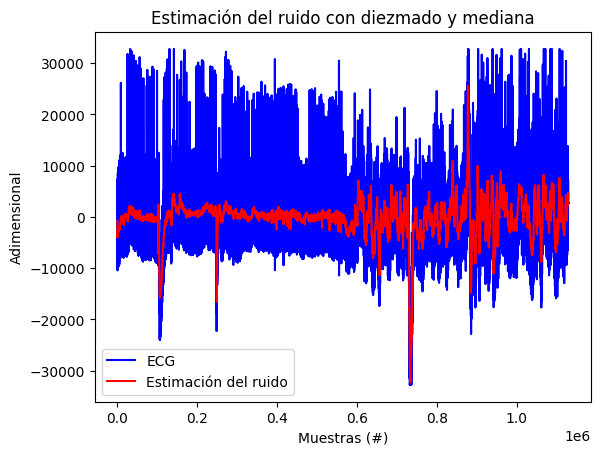

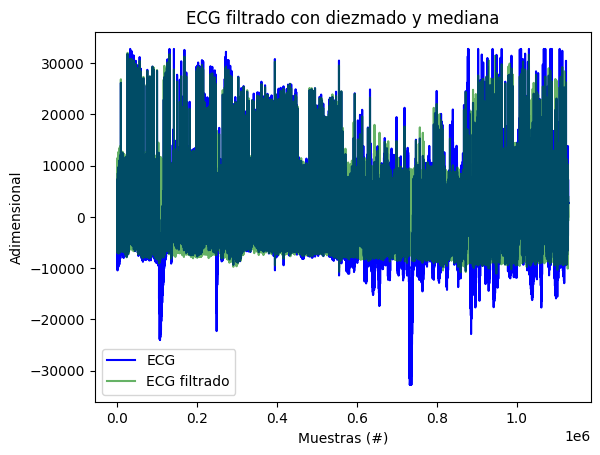

In [5]:
D = 10 # Factor de diezmado

# La función aplica el filtro anti aliasing y reduce fs de 1000Hz a 100Hz
ecg_down = sig.decimate(ecg_one_lead, D)
fs_diezmada = fs / D

# Aplicación del filtro de mediana ajustando las ventanas para menos muestras
# ventana de 200 ms: en fs/M son 200*(fs/D)/1000 = (200*1000/10)/1000 = 20 muestras pero necesito impar
w_200 = 21 
w_600 = 61
b_diezmado = sig.medfilt(sig.medfilt(ecg_down, w_200), w_600)

# Interpolación para volver a la fs original
# índices de las muestras originales correspondientes a los puntos de la señal diezmada
indice = np.arange(len(b_diezmado)) * D

f_interp = interp1d(indice, b_diezmado, kind='cubic', fill_value="extrapolate") # Función de interpolación

b_multirate = f_interp(np.arange(len(ecg_one_lead))) # Estimación del ruido
ecg_filt_med_multi=ecg_one_lead-b_multirate

plt.figure()
plt.title('Estimación del ruido con diezmado y mediana')
plt.plot(ecg_one_lead, color='blue', label='ECG')
plt.plot(b_multirate, color='red', label='Estimación del ruido')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()

plt.figure()
plt.title('ECG filtrado con diezmado y mediana')
plt.plot(ecg_one_lead, color='blue', label='ECG')
plt.plot(ecg_filt_med_multi, color='green', label='ECG filtrado', alpha=0.6)
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()

- El diezmado reduce el costo computacional y mejora la resolución al estimar el ruido de baja frecuencia con el filtro de mediana a través de la reducción de la fs, el aumento del espaciado temporal entre muestras, y en efecto, la obtención de un ancho de banda comparable con la señal. Posteriormente, se aplica una interpolación para así regresar a la fs original. Cabe destacar que se aplica previamente un filtro pasa bajos para evitar el aliasing por parte de los componentes de alta energía.

Bonus 2)

- El detector basado en el filtro adaptado no podría funcionar idóneamente con un latido perteneciente a otro registro o paciente ya que este se basa en la correlación de la señal con un patrón derivado de la misma, el cual posee una morfología dependiente de factores fisiológicos y anatómicos intrínsecos de cada paciente en conjunto al ruido inducido por los electrodos. Entonces, se altera la correlación, así como también la matriz de confusión, si previamente no se calibra el filtro respecto del latido de referencia. Excepcionalmente, este funcionaría si la señal es muy semejante y limpia en ruido.

# Conclusiones
Finalmente, se deduce que la técnicas de procesamiento no lineal aplicadas sobre el ECG presentan mejores resultados que los filtros lineales al mitigar las interferencias de baja frecuencia.
Al estimar la línea de base, se observó que el filtro de mediana es capaz de aproximar abruptamente su tendencia sin requerir información previa, y la interpolación mediante splines cúbicos brinda una reconstrucción más suave, pero dependiente de los nodos y la morfología. Con respecto a la detección de latidos, el filtro adaptado constató la maximización de la SNR, al correlacionar la señal con un patrón conocido, mediante las métricas resultante de la matriz de confusión, es decir, 99,9% de sensibilidad y precisión. A su vez, este último depende de su sincronización a través de la compensación del retardo y el establecimiento de umbrales de detección.
En adición, la aplicación de técnicas multirate, tales como el diezmado y la interpolación, redujo el costo computacional y posibilitó un análisis comparable con el ancho de banda. 
También, se infiere que la generalización del detector de latidos es inadecuada sin una etapa previa de calibración de la morfología del patrón respecto al paciente para así no incidir sobre la correlación.

# Autoevaluación
A) Sí, resolví la tarea con seguridad.

B) Lo aprendido en esta tarea fueron la capacidad de diseñar y evaluar filtros no lineales a partir de la estimación y sustracción del ruido de baja frecuencia, y la aplicación de técnicas multirate para optimizar las metodologías.

C) No fue utilizada ninguna IA.